In [160]:
# import matplotlib
# matplotlib.use('Agg')
import sys
sys.path.append('../')
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from os import remove
from pprint import pprint
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from base_learners import cnn,lstm,bi_lstm,cnn_bi_lstm,cnn_lstm
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]
from mlens.visualization import corrmat
from sklearn.model_selection import StratifiedKFold
from xgboost_tuner.tuner import tune_xgb_params
from xgboost import XGBClassifier

In [82]:
def load_data_from_file(filename):
    with open(filename,'r', errors='ignore') as fin:
        lines = fin.readlines()
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [83]:
train_labels,train_sentences = load_data_from_file('dataset/sst1/stsa.fine.train')
dev_label,dev_sentence = load_data_from_file('dataset/sst1/stsa.fine.dev')
test_labels,test_sentences = load_data_from_file('dataset/sst1/stsa.fine.test')

In [84]:
train_sentences = train_sentences+dev_sentence
train_labels = train_labels+dev_label

In [85]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(9645, 9645, 2210, 2210)

In [86]:
train_labels = train_labels[:500]
train_sentences = train_sentences[:500]
test_labels=test_labels[:100]
test_sentences = test_sentences[:100]

In [87]:
number_of_classes = len(set(train_labels))
number_of_classes

5

In [88]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(500, 500, 100, 100)

In [89]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [90]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [91]:
print("cleaning data")
trainX = [clean_sentence(s) for s in train_sentences]
testX = [clean_sentence(s) for s in test_sentences]
trainY = np.array(train_labels)
testY=test_labels

cleaning data


In [92]:
max_len = 24

In [93]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [94]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [95]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [96]:
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [97]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [98]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)
testX = encode_text(tokenizer, testX, max_len)
trainY = to_categorical(trainY,num_classes=number_of_classes)

Max document length: 24
Vocabulary size: 2674


In [19]:
# godin_model = load_godin_word_embedding("../word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('../word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [99]:
embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
# embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)

## base models

In [100]:
cnn_parameter = {'batch': 8,
                'dropout': 0.6,
                'em': 'embedding_matrix_word2vec',
                'em_trainable_flag': True,
                'epoch': 10,
                'filter_size': 6,
                'learning_rate': 0.0001,
                'n_dense': 200,
                'n_filters': 100}

lstm_parameter={'batch': 64,
                    'dropout': 0.6,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 20,
                    'learning_rate': 0.0034157107277860235,
                    'units_out': 128}

cnn_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 10,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.4,
                    'n_filters': 100,
                    'units_out': 64}

cnn_bi_lstm_parameter={'batch': 8,
                    'conv_dropout': 0.5,
                    'em': 'embedding_matrix_word2vec',
                    'em_trainable_flag': False,
                    'epoch': 5,
                    'filter_size': 1,
                    'learning_rate': 0.001,
                    'lstm_dropout': 0.2,
                    'n_filters': 100,
                    'units_out': 64}

bi_lstm_parameter={'batch':8,
                 'dropout': 0.6,
                 'em': 'embedding_matrix_word2vec',
                 'em_trainable_flag': False,
                 'epoch': 5,
                 'learning_rate': 0.0001,
                 'units_out': 256}

In [101]:
# cnn
# 0.4710
def init_cnn():
    return cnn(length=max_len,
               vocab_size=vocab_size,
               learning_rate=cnn_parameter['learning_rate'],
               n_dense=cnn_parameter['n_dense'],
               dropout=cnn_parameter['dropout'],
               n_filters=cnn_parameter['n_filters'],
               filter_size=cnn_parameter['filter_size'],
               em=eval(cnn_parameter['em']),
               number_of_classes=number_of_classes,
               em_trainable_flag=cnn_parameter['em_trainable_flag'])

In [102]:
#  lstm
# 0.4701
def init_lstm():
    return lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=lstm_parameter['learning_rate'],
                dropout=lstm_parameter['dropout'],
                units_out=lstm_parameter['units_out'],
                em=eval(lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=lstm_parameter['em_trainable_flag'])

In [103]:
# bi_lstm
# 0.4529
def init_bi_lstm():
    return bi_lstm(length=max_len,
                vocab_size=vocab_size,
                learning_rate=bi_lstm_parameter['learning_rate'],
                dropout=bi_lstm_parameter['dropout'],
                units_out=bi_lstm_parameter['units_out'],
                em=eval(bi_lstm_parameter['em']),
                number_of_classes=number_of_classes,
                em_trainable_flag=bi_lstm_parameter['em_trainable_flag'])

In [104]:
# cnn_lstm
# 0.4179
def init_cnn_lstm():
    return cnn_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_lstm_parameter['learning_rate'],
                    n_filters=cnn_lstm_parameter['n_filters'],
                    filter_size=cnn_lstm_parameter['filter_size'],
                    em=eval(cnn_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_lstm_parameter['lstm_dropout'],
                    units_out=cnn_lstm_parameter['units_out'])

In [105]:
# cnn_bi_lstm
# 0.4705
def init_cnn_bi_lstm():
    return cnn_bi_lstm(length=max_len,
                    vocab_size=vocab_size,
                    learning_rate=cnn_bi_lstm_parameter['learning_rate'],
                    n_filters=cnn_bi_lstm_parameter['n_filters'],
                    filter_size=cnn_bi_lstm_parameter['filter_size'],
                    em=eval(cnn_bi_lstm_parameter['em']),
                    number_of_classes=number_of_classes,
                    em_trainable_flag=cnn_bi_lstm_parameter['em_trainable_flag'],
                    conv_dropout=cnn_bi_lstm_parameter['conv_dropout'],
                    l_or_g_dropout=cnn_bi_lstm_parameter['lstm_dropout'],
                    units_out=cnn_bi_lstm_parameter['units_out'])

In [106]:
def get_pred_of_model(m,epoch,batch,trainX,trainY,testX,testY):
    history = m.fit(trainX,trainY,epochs=epoch,batch_size=batch,verbose=2)
    pred = m.predict(testX)    
    pred_class = np.argmax(pred,axis=1)
    pred_class=pred_class.astype(int)
    acc = accuracy_score(testY,pred_class)
    print(acc)
#     print(pred)
    return acc,pred_class,pred

In [107]:
pred_prob_base = np.zeros((len(testX),number_of_classes,5))
pred_class_base = np.zeros((len(testX),5),dtype=np.int32)
acc_results={}

In [108]:
cnn_base = init_cnn()
acc_results['cnn'],pred_class_base[:,0],pred_prob_base[:,:,0] = get_pred_of_model(cnn_base,cnn_parameter['epoch'],cnn_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
__________

In [109]:
lstm_base = init_lstm()
acc_results['lstm'],pred_class_base[:,1],pred_prob_base[:,:,1] = get_pred_of_model(lstm_base,lstm_parameter['epoch'],lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 1,022,493
Trainable params: 220,293
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.4973 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4913 - acc: 0.8016
Epoch 3/20
 - 1s - loss: 0.4894 - acc: 0.8000
Epoch 4/20
 - 1s - loss: 0.4847 - acc: 0.8000
Epoch 5/20
 - 1s - loss: 0.4745 - acc: 0.7996
Epoch 6/20
 - 1s - loss: 0.4805 - acc: 0.8008
Epoch 7/20
 - 1s - loss: 0.4786 - acc: 0.8000
Epoch 8/20
 - 1s - loss: 0.4748 - acc: 0.7956
Epoch 9/20
 - 1s - 

In [110]:
bi_lstm_base=init_bi_lstm()
acc_results['bi_lstm'],pred_class_base[:,2],pred_prob_base[:,:,2] = get_pred_of_model(bi_lstm_base,bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 2565      
Total params: 1,945,501
Trainable params: 1,143,301
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/5
 - 9s - loss: 0.4959 - acc: 0.8000
Epoch 2/5
 - 5s - loss: 0.4859 - acc: 0.8000
Epoch 3/5
 - 5s - loss: 0.4819 - acc: 0.8000
Epoch 4/5
 - 5s - loss: 0.4741 - acc: 0.8000
Epoch 5/5
 - 5s - loss: 0.4664 - acc: 0.8024
0.33


In [111]:
cnn_lstm_base = init_cnn_lstm()
acc_results['cnn_lstm'],pred_class_base[:,3],pred_prob_base[:,:,3] = get_pred_of_model(cnn_lstm_base,cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total para

In [112]:
cnn_bi_lstm_base = init_cnn_bi_lstm()
acc_results['cnn_bi_lstm'],pred_class_base[:,4],pred_prob_base[:,:,4] = get_pred_of_model(cnn_bi_lstm_base,cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],trainX,trainY,testX,testY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 100)           30100     
_________________________________________________________________
dropout_20 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645       
Total para

In [113]:
acc_results

{'bi_lstm': 0.33,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32}

In [114]:
pred_class_base[:10]

array([[3, 1, 3, 2, 1],
       [3, 1, 3, 3, 3],
       [3, 1, 1, 2, 2],
       [3, 1, 1, 2, 1],
       [3, 1, 3, 2, 1],
       [3, 1, 3, 1, 1],
       [3, 4, 3, 4, 4],
       [3, 1, 3, 2, 3],
       [3, 1, 3, 2, 1],
       [3, 1, 3, 3, 3]], dtype=int32)

In [115]:
pred_prob_base[:2]

array([[[0.184609  , 0.19191468, 0.17459805, 0.22070129, 0.18744427],
        [0.22054781, 0.28886583, 0.23154749, 0.29662412, 0.26736817],
        [0.19308037, 0.23588656, 0.19251443, 0.34678721, 0.25845081],
        [0.22191621, 0.20521602, 0.23531461, 0.08852047, 0.18886283],
        [0.1798466 , 0.07811686, 0.16602542, 0.04736681, 0.09787392]],

       [[0.1545662 , 0.16193821, 0.14373671, 0.01979197, 0.02945141],
        [0.2284821 , 0.29202375, 0.21908258, 0.04751518, 0.13447636],
        [0.20158379, 0.22899753, 0.1802468 , 0.12259176, 0.11211661],
        [0.25179291, 0.23782246, 0.27901351, 0.71947771, 0.50486356],
        [0.16357507, 0.07921812, 0.17792036, 0.09062334, 0.21909206]]])

## Analyzing performance of base models 

In [116]:
number_of_base_models = 5

In [117]:
correct_predicted_by_all = 0
incorrect_predicted_by_all = 0
correct_predicted_by_some=[0 for _ in range(number_of_base_models-1)] #index0 = correct predicted by 1, index1 = correct predicted by 2 and so on.

In [118]:
# pred_class_base[0],np.bincount(pred_class_base[0]),len(np.bincount(pred_class_base[0])),testY[0]

In [119]:
for x,y in zip(pred_class_base,testY):
    bin_count = np.bincount(x)
    if len(bin_count)<=y or bin_count[y]==0:
        incorrect_predicted_by_all+=1
    elif bin_count[y] == number_of_base_models:
        correct_predicted_by_all+=1
    else:
        correct_predicted_by_some[bin_count[y]-1]+=1

In [120]:
incorrect_predicted_by_all,correct_predicted_by_all,correct_predicted_by_some

(29, 2, [25, 21, 15, 8])

In [121]:
if sum(correct_predicted_by_some)+correct_predicted_by_all+incorrect_predicted_by_all == len(testY):
    print("results look good")
else:
    print("something went wrong")

results look good


In [122]:
acc_results['base_model_counts']={}

In [123]:
acc_results['base_model_counts']['correct_predicted_by_all'] = correct_predicted_by_all
acc_results['base_model_counts']['incorrect_predicted_by_all'] = incorrect_predicted_by_all
acc_results['base_model_counts']['correct_predicted_by_some'] = correct_predicted_by_some

In [124]:
acc_results

{'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32}

## prediction corelation

In [125]:
pred_df = pd.DataFrame(pred_class_base)
pred_df.columns = ["cnn","lstm","bi_lstm","cnn_lstm","cnn_bi_lstm"]

In [126]:
pred_df.head()

,cnn,lstm,bi_lstm,cnn_lstm,cnn_bi_lstm
0,3,1,3,2,1
1,3,1,3,3,3
2,3,1,1,2,2
3,3,1,1,2,1
4,3,1,3,2,1


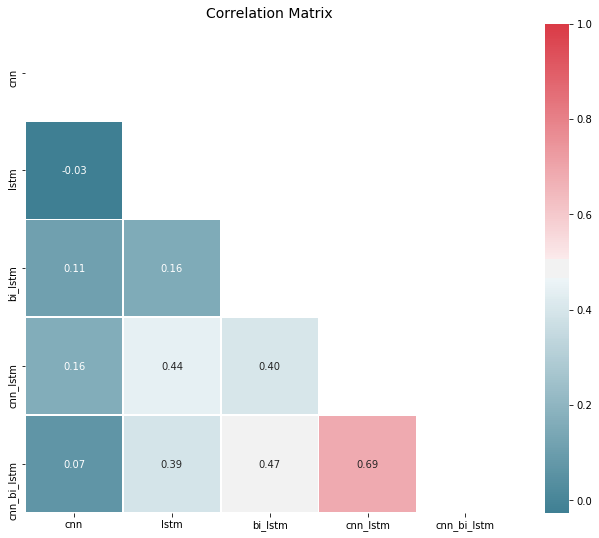

In [127]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_base.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## average

In [128]:
avg_pred_prob = pred_prob_base.mean(axis=2)

In [129]:
avg_pred_class = np.argmax(avg_pred_prob,axis=1)
avg_pred_class=avg_pred_class.astype(int)

In [130]:
acc = accuracy_score(testY,avg_pred_class)
acc

0.36

In [131]:
acc_results['average'] = acc

In [132]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32}

In [133]:
pred_df['average']=avg_pred_class

## Majority

In [134]:
majority_pred_class = [int(np.argmax(np.bincount(x))) for x in pred_class_base]

In [135]:
acc = accuracy_score(testY,majority_pred_class)
acc

0.36

In [136]:
acc_results['majority'] = acc

In [137]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36}

In [138]:
pred_df['majority']=majority_pred_class

## Blend ensemble

In [139]:
seed=42

In [140]:
baseX, devX, baseY, devY = train_test_split(trainX, train_labels, test_size=0.10, random_state=seed)

In [141]:
baseY = np.array(baseY)
baseY = to_categorical(baseY,num_classes=number_of_classes)

In [142]:
len(baseX),len(baseY),len(devX),len(devY)

(450, 450, 50, 50)

In [143]:
metaX = np.zeros((len(devY),5),dtype=np.int32)

In [144]:
_,metaX[:,0],_ = get_pred_of_model(init_cnn(),cnn_parameter['epoch'],cnn_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 200)               0         
__________

In [145]:
_,metaX[:,1],_ = get_pred_of_model(init_lstm(),lstm_parameter['epoch'],lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 645       
Total params: 1,022,493
Trainable params: 220,293
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/20
 - 3s - loss: 0.4963 - acc: 0.8000
Epoch 2/20
 - 1s - loss: 0.4876 - acc: 0.7991
Epoch 3/20
 - 1s - loss: 0.4934 - acc: 0.7987
Epoch 4/20
 - 1s - loss: 0.4901 - acc: 0.7996
Epoch 5/20
 - 1s - loss: 0.4903 - acc: 0.8000
Epoch 6/20
 - 1s - loss: 0.4881 - acc: 0.7978
Epoch 7/20
 - 1s - loss: 0.4869 - acc: 0.8004
Epoch 8/20
 - 1s - loss: 0.4882 - acc: 0.8000
Epoch 9/20
 - 1s - 

In [146]:
_,metaX[:,2],_ = get_pred_of_model(init_bi_lstm(),bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 2565      
Total params: 1,945,501
Trainable params: 1,143,301
Non-trainable params: 802,200
_________________________________________________________________
None
Epoch 1/5
 - 7s - loss: 0.4972 - acc: 0.8000
Epoch 2/5
 - 5s - loss: 0.4883 - acc: 0.8000
Epoch 3/5
 - 5s - loss: 0.4812 - acc: 0.8004
Epoch 4/5
 - 5s - loss: 0.4776 - acc: 0.8009
Epoch 5/5
 - 5s - loss: 0.4712 - acc: 0.8018
0.28


In [147]:
_,metaX[:,3],_ = get_pred_of_model(init_cnn_lstm(),cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 100)           30100     
_________________________________________________________________
dropout_25 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total para

In [148]:
_,metaX[:,4],_ = get_pred_of_model(init_cnn_bi_lstm(),cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],baseX,baseY,devX,devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 24, 300)           802200    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 100)           30100     
_________________________________________________________________
dropout_27 (Dropout)         (None, 24, 100)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 645       
Total para

In [149]:
len(devY),len(metaX)

(50, 50)

Logistic Regressing meta model

In [150]:
meta_model=LogisticRegression()

In [151]:
meta_model.fit(metaX,devY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
blend_pred_class = meta_model.predict(pred_class_base)

In [153]:
acc = accuracy_score(testY,blend_pred_class)
acc

0.34

In [154]:
acc_results['blend'] = acc

In [155]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'blend': 0.34,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36}

In [156]:
pred_df['blend']=blend_pred_class

XGboost meta model

In [162]:
best_params, history = tune_xgb_params(
    cv_folds=10,
    label=np.array(devY),
    metric_sklearn='accuracy',
    metric_xgb='merror',
    n_jobs=4,
    objective='multi:softprob',
    random_state=seed,
    strategy='randomized',
    train=metaX,
    colsample_bytree_loc=0.5,
    colsample_bytree_scale=0.2,
    subsample_loc=0.5,
    subsample_scale=0.2
)

[0]	train-merror:0.49081+0.0189381	test-merror:0.604605+0.0658836
[1]	train-merror:0.489582+0.0182909	test-merror:0.556871+0.0664973
[2]	train-merror:0.457604+0.0501957	test-merror:0.591959+0.0918336
[3]	train-merror:0.457604+0.0501957	test-merror:0.612793+0.103335
[4]	train-merror:0.437996+0.040323	test-merror:0.633626+0.121074
[5]	train-merror:0.407916+0.041854	test-merror:0.657237+0.0404949
[6]	train-merror:0.398392+0.0315514	test-merror:0.595249+0.0937433
[7]	train-merror:0.398392+0.0315514	test-merror:0.612793+0.103335
[8]	train-merror:0.407916+0.041854	test-merror:0.657237+0.0404949
[9]	train-merror:0.418668+0.0290098	test-merror:0.612793+0.103335
[10]	train-merror:0.427243+0.0543302	test-merror:0.616082+0.116188
[11]	train-merror:0.387639+0.0465118	test-merror:0.595249+0.0937433
[12]	train-merror:0.406967+0.0600247	test-merror:0.638304+0.0885817
[13]	train-merror:0.407916+0.041854	test-merror:0.639693+0.0361796
[14]	train-merror:0.397443+0.0531847	test-merror:0.638304+0.0885817


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3333333333333333, total=   0.0s
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.25, total=   0.1s
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.2, total=   0.0s
[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.51161

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.25, total=   0.0s
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3333333333333333, total=   0.0s
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.170766873616

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.4, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.125, total=   0.0s
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749080237694725, gamma=0.8556428757689246, max_depth=9, min_child_weight=5, reg_alpha=1.1707668736166799, reg_lambda=1.1706847847459028, subsample=0.5116167224336399, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.375, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.5, total=   0.0s
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.14285714285714285, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3333333333333333, total=   0.0s


[Parallel(n_jobs=4)]: Batch computation too fast (0.0642s.) Setting batch_size=6.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1817s.) Setting batch_size=12.


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s
[CV] colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201 
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV]  colsample_bytree=0.673235229154987, gamma=0.541003510568888, max_depth=9, min_child_weight=3, reg_alpha=2.3473719296747606, reg_lambda=2.712800217929823, subsample=0.5363649934414201, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.25, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV] colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5366809019706867, gamma=0.27381801866358396, max_depth=7, min_child_weight=9, reg_alpha=4.082225404756636, reg_lambda=7.619379988079304, subsample=0.5278987721304084, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.77

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.125, total=   0.0s
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.4, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.2, total=   0.1s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.14285714285714285, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.25, total=   0.0s
[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.16666666666666666, total=   0.0s
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.5, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5584289297070436, gamma=0.32972565896432254, max_depth=4, min_child_weight=7, reg_alpha=0.12227588747032872, reg_lambda=1.7777565856121607, subsample=0.6719880813472641, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.6666666666666666, total=   0.0s
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.4, total=   0.0s
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsam

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV] colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832 
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done  20 tasks      | elapsed:    0.3s
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packag

[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsamp

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.636061507717556, gamma=0.4054493267725887, max_depth=3, min_child_weight=4, reg_alpha=0.47562892158568226, reg_lambda=3.3232717137492602, subsample=0.5770833005079832, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822 
[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.6666666666666666, total=   0.0s
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.125, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.25, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.5714285714285714, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5031932504440428, gamma=0.2078044430599341, max_depth=8, min_child_weight=8, reg_alpha=4.112724560515945, reg_lambda=6.104218249855111, subsample=0.5623422152178822, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.42857142857142855, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.25, total=   0.0s
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964,

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.5714285714285714, total=   0.0s
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.4, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.6529220038

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.42857142857142855, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.4, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.25, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.4, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.2, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.25, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.40880519

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.25, total=   0.0s
[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.25, total=   0.0s
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234, score=0.5, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.6843748470046234 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.5, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV]  colsample_bytree=0.6040136042355622, gamma=0.4920392514089517, max_depth=7, min_child_weight=2, reg_alpha=1.0931915802693124, reg_lambda=4.408805194743053, subsample=0.684374847004623

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159 
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5176985004103839, gamma=0.1763845761772307, max_depth=10, min_child_weight=8, reg_alpha=2.3659662473001166, reg_lambda=3.2959529921449215, subsample=0.6079384264778159, score=0.3333333333333333, total=   0.0s
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.125, total=   0.0s
[CV] colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6173502331327696, gamma=0.8687297765377242, max_depth=10, min_child_weight=1, reg_alpha=0.21768401236748952, reg_lambda=1.376504551231964, subsample=0.578976303635114, score=0.6666666666666666, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 
[CV]  colsample_bytree=0.5586976349436076, gamma=0.012671840443576011, max_depth=4, min_child_weight=1, reg_alpha=4.65292200385551, reg_lambda=3.3888370483667076, subsample=0.6211919949562023, score=0.14285714285714285, total=   0.0s
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV] colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.125, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.6852601757026698, gamma=0.5859693229517501, max_depth=8, min_child_weight=9, reg_alpha=7.540766447737414, reg_lambda=5.498234878924102, subsample=0.5127116700572047, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.14285714285714285, total=   0.0s
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.14285714285714285, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.8s
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packag

[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.4, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.4, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862 
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.12545444405

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6943424190778208, gamma=0.7640224418394755, max_depth=6, min_child_weight=10, reg_alpha=3.8985094032993923, reg_lambda=4.2194818017196285, subsample=0.5080867179076862, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 
[CV]  colsample_bytree=0.5621964643431324, gamma=0.29266498982407235, max_depth=4, min_child_weight=8, reg_alpha=2.289425385000076, reg_lambda=8.421436891829407, subsample=0.576585374950758, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3333333333333333, total=   0.0s
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.2, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.42857142857142855, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.5, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.5, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.2, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256 
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5278662908811751, gamma=0.5439756413500355, max_depth=5, min_child_weight=7, reg_alpha=4.042468014465938, reg_lambda=2.5087852179226826, subsample=0.6859395304685146, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.5, total=   0.0s
[CV]  colsample_bytree=0.6421325779371575, gamma=0.0998017387306482, max_depth=4, min_child_weight=7, reg_alpha=13.16764110306062, reg_lambda=5.1254544440543235, subsample=0.6391032172852256, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.375, total=   0.0s
[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.5714285714285714, total=   0.0s
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.6666666666666666, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.725578072433

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.5, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.6666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.3333333333333333, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6616240759128834, gamma=0.5700633808593811, max_depth=7, min_child_weight=4, reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446, subsample=0.6614880310328125, score=0.6666666666666666, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.25, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.375, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.125, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.42857142857142855, total=   0.0s
[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.2857142857142857, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.16666666666666666, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.2857142857142857, total=   0.0s
[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.2857142857142857, total=   0.0s
[CV] colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987 
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043 
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.14285714285714285, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.6792182599846986, gamma=0.2862031274746775, max_depth=2, min_child_weight=1, reg_alpha=1.960540765660788, reg_lambda=7.317574740660593, subsample=0.6636029531844987, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 
[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.725578072433

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.16666666666666666, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.4, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6721461166512687, gamma=0.006256917478071633, max_depth=9, min_child_weight=9, reg_alpha=9.72557807243393, reg_lambda=0.7666822875807018, subsample=0.5538824667597043, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.5, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.5, total=   0.0s


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.3333333333333333, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5488251044495548, gamma=0.1514619379556375, max_depth=9, min_child_weight=9, reg_alpha=3.313691566891067, reg_lambda=0.7323640337080811, subsample=0.5507830827868689, score=0.0, total=   0.0s
[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.0, total=   0.0s
[CV] colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366 


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5493752125677203, gamma=0.6266738455558095, max_depth=4, min_child_weight=1, reg_alpha=2.2088301161300645, reg_lambda=0.4208254259058871, subsample=0.5690142496053366, score=0.6666666666666666, total=   0.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


[0]	train-merror:0.709+0.0239212	test-merror:0.717836+0.0365788
[1]	train-merror:0.740978+0.0279199	test-merror:0.736769+0.0417015
[2]	train-merror:0.740978+0.0279199	test-merror:0.736769+0.0417015
[3]	train-merror:0.674311+0.0970455	test-merror:0.625658+0.164906
[4]	train-merror:0.674311+0.0970455	test-merror:0.625658+0.164906
[5]	train-merror:0.674311+0.0970455	test-merror:0.625658+0.164906
[6]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787
[7]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787
[8]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787
[9]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787
[10]	train-merror:0.642053+0.0710979	test-merror:0.608114+0.148531
[11]	train-merror:0.642053+0.0710979	test-merror:0.608114+0.148531
[12]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787
[13]	train-merror:0.642053+0.0710979	test-merror:0.608114+0.148531
[14]	train-merror:0.708719+0.0267902	test-merror:0.719225+0.0224787

In [163]:
best_params

{'colsample_bytree': 0.6616240759128834,
 'gamma': 0.5700633808593811,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 2,
 'nthread': 4,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': 0.4853877467402019,
 'reg_lambda': 4.843224952664446,
 'scale_pos_weight': 1,
 'subsample': 0.6614880310328125}

In [165]:
meta_model_xg = XGBClassifier(colsample_bytree=best_params['colsample_bytree'],
                              gamma=best_params['gamma'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              min_child_weight=best_params['min_child_weight'],
                              n_estimators=best_params['n_estimators'],
                              nthread=best_params['nthread'],
                              objective=best_params['objective'],
                              random_state=best_params['random_state'],
                              reg_alpha=best_params['reg_alpha'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              subsample=best_params['subsample'])

In [166]:
meta_model_xg.fit(metaX,devY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6616240759128834, gamma=0.5700633808593811,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=None, n_estimators=2, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=42,
       reg_alpha=0.4853877467402019, reg_lambda=4.843224952664446,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6614880310328125)

In [167]:
blend_pred_class_xg = meta_model_xg.predict(pred_class_base)

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [168]:
acc = accuracy_score(testY,blend_pred_class)
acc

0.34

In [169]:
acc_results['blend_xg'] = acc

In [170]:
acc_results

{'average': 0.36,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [25, 21, 15, 8],
  'incorrect_predicted_by_all': 29},
 'bi_lstm': 0.33,
 'blend': 0.34,
 'blend_xg': 0.34,
 'cnn': 0.26,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.29,
 'lstm': 0.32,
 'majority': 0.36}

In [ ]:
pred_df['blend_xg']=blend_pred_class

## Stacked ensemble

In [86]:
np.random.seed(seed)

In [87]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [88]:
stacked_metaX=np.array([[0, 0, 0, 0,0]],dtype=np.int64)

In [89]:
stacked_metaY = []

In [90]:
count=1

In [91]:
trainX=[clean_sentence(x) for x in train_sentences]

In [92]:
trainY=train_labels

In [93]:
trainY=np.array(trainY)
trainX=np.array(trainX)

In [94]:
for train,test in kfold.split(trainX,trainY):
    print("----------------------itr = {}--------------".format(count))
    stacked_trainX = list(trainX[train])
    stacked_trainY = list(trainY[train])
    stacked_testX = list(trainX[test])
    stacked_testY = list(trainY[test])
    
    tokenizer = create_tokenizer(stacked_trainX)
    vocab_size = len(tokenizer.word_index) + 1
    stacked_trainX = encode_text(tokenizer, stacked_trainX, max_len)
    stacked_testX = encode_text(tokenizer, stacked_testX, max_len)
    stacked_trainY = to_categorical(stacked_trainY,num_classes=number_of_classes)
    
    embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
    
    for i in stacked_testY:
        stacked_metaY.append(i)
        
    temp = np.zeros((len(stacked_testY),5),dtype=np.int64)
    
    _,temp[:,0],_ = get_pred_of_model(init_cnn(),cnn_parameter['epoch'],cnn_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,1],_ = get_pred_of_model(init_lstm(),lstm_parameter['epoch'],lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,2],_ = get_pred_of_model(init_bi_lstm(),bi_lstm_parameter['epoch'],bi_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,3],_ = get_pred_of_model(init_cnn_lstm(),cnn_lstm_parameter['epoch'],cnn_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    _,temp[:,4],_ = get_pred_of_model(init_cnn_bi_lstm(),cnn_bi_lstm_parameter['epoch'],cnn_bi_lstm_parameter['batch'],stacked_trainX,stacked_trainY,stacked_testX,stacked_testY)
    
    stacked_metaX = np.concatenate((stacked_metaX, temp), axis=0)
    count+=1

----------------------itr = 1--------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 24, 300)           347400    
_________________________________________________________________
dropout_15 (Dropout)         (None, 24, 300)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 19, 100)           180100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
activation_5 (Activation)    (No

Epoch 1/10
 - 3s - loss: 0.5265 - acc: 0.7944
Epoch 2/10
 - 0s - loss: 0.5033 - acc: 0.7966
Epoch 3/10
 - 0s - loss: 0.5106 - acc: 0.7989
Epoch 4/10
 - 0s - loss: 0.4913 - acc: 0.8000
Epoch 5/10
 - 1s - loss: 0.4855 - acc: 0.7966
Epoch 6/10
 - 0s - loss: 0.4852 - acc: 0.7978
Epoch 7/10
 - 0s - loss: 0.4904 - acc: 0.8011
Epoch 8/10
 - 0s - loss: 0.4798 - acc: 0.7989
Epoch 9/10
 - 0s - loss: 0.4857 - acc: 0.7989
Epoch 10/10
 - 0s - loss: 0.4741 - acc: 0.8011
0.23809523809523808
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 24, 300)           343800    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 645       
Total params: 564,093
Trainable params: 220,293
Non-train

 - 0s - loss: 0.5209 - acc: 0.7944
Epoch 3/10
 - 0s - loss: 0.4914 - acc: 0.7978
Epoch 4/10
 - 0s - loss: 0.4961 - acc: 0.7955
Epoch 5/10
 - 0s - loss: 0.4900 - acc: 0.7955
Epoch 6/10
 - 0s - loss: 0.4982 - acc: 0.7989
Epoch 7/10
 - 0s - loss: 0.4957 - acc: 0.7989
Epoch 8/10
 - 0s - loss: 0.4822 - acc: 0.8000
Epoch 9/10
 - 0s - loss: 0.4833 - acc: 0.8011
Epoch 10/10
 - 0s - loss: 0.4860 - acc: 0.7978
0.3333333333333333
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 24, 300)           343800    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 645       
Total params: 564,093
Trainable params: 220,293
Non-trainable params: 343,800
_____________________________________

Epoch 4/10
 - 0s - loss: 0.5040 - acc: 0.7966
Epoch 5/10
 - 0s - loss: 0.4935 - acc: 0.7933
Epoch 6/10
 - 0s - loss: 0.4752 - acc: 0.8022
Epoch 7/10
 - 0s - loss: 0.4915 - acc: 0.8022
Epoch 8/10
 - 0s - loss: 0.4982 - acc: 0.8034
Epoch 9/10
 - 0s - loss: 0.4731 - acc: 0.7989
Epoch 10/10
 - 0s - loss: 0.4813 - acc: 0.8022
0.2857142857142857
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 24, 300)           342000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 645       
Total params: 562,293
Trainable params: 220,293
Non-trainable params: 342,000
_________________________________________________________________
None
Epoch 1/20
 - 3s - loss: 0.4995 - acc: 0.8000
E

 - 0s - loss: 0.5014 - acc: 0.7944
Epoch 6/10
 - 0s - loss: 0.4884 - acc: 0.8000
Epoch 7/10
 - 0s - loss: 0.4924 - acc: 0.7989
Epoch 8/10
 - 0s - loss: 0.4955 - acc: 0.7956
Epoch 9/10
 - 0s - loss: 0.4878 - acc: 0.8011
Epoch 10/10
 - 0s - loss: 0.4881 - acc: 0.7989
0.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 24, 300)           348600    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 645       
Total params: 568,893
Trainable params: 220,293
Non-trainable params: 348,600
_________________________________________________________________
None
Epoch 1/20
 - 4s - loss: 0.4992 - acc: 0.8000
Epoch 2/20
 - 0s - loss: 0.4925 - acc: 0.8000
Epoch 3/20
 - 0s - loss: 0.

 - 0s - loss: 0.4881 - acc: 0.8011
Epoch 9/10
 - 0s - loss: 0.4983 - acc: 0.7967
Epoch 10/10
 - 0s - loss: 0.4809 - acc: 0.7989
0.3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 24, 300)           338400    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 645       
Total params: 558,693
Trainable params: 220,293
Non-trainable params: 338,400
_________________________________________________________________
None
Epoch 1/20
 - 5s - loss: 0.5003 - acc: 0.8000
Epoch 2/20
 - 0s - loss: 0.4955 - acc: 0.8000
Epoch 3/20
 - 0s - loss: 0.4880 - acc: 0.8000
Epoch 4/20
 - 0s - loss: 0.4866 - acc: 0.8000
Epoch 5/20
 - 0s - loss: 0.4802 - acc: 0.7989
Epoch 6/20
 - 0s - loss: 0.

Epoch 1/20
 - 8s - loss: 0.4992 - acc: 0.8000
Epoch 2/20
 - 0s - loss: 0.4930 - acc: 0.8000
Epoch 3/20
 - 0s - loss: 0.4873 - acc: 0.8011
Epoch 4/20
 - 0s - loss: 0.4829 - acc: 0.8022
Epoch 5/20
 - 0s - loss: 0.4821 - acc: 0.7989
Epoch 6/20
 - 0s - loss: 0.4819 - acc: 0.7989
Epoch 7/20
 - 0s - loss: 0.4881 - acc: 0.8000
Epoch 8/20
 - 0s - loss: 0.4846 - acc: 0.7989
Epoch 9/20
 - 0s - loss: 0.4788 - acc: 0.8000
Epoch 10/20
 - 0s - loss: 0.4822 - acc: 0.8011
Epoch 11/20
 - 0s - loss: 0.4769 - acc: 0.8022
Epoch 12/20
 - 0s - loss: 0.4802 - acc: 0.7978
Epoch 13/20
 - 0s - loss: 0.4657 - acc: 0.8022
Epoch 14/20
 - 0s - loss: 0.4494 - acc: 0.8111
Epoch 15/20
 - 0s - loss: 0.4804 - acc: 0.7922
Epoch 16/20
 - 0s - loss: 0.4616 - acc: 0.8089
Epoch 17/20
 - 0s - loss: 0.4686 - acc: 0.8044
Epoch 18/20
 - 0s - loss: 0.4713 - acc: 0.7989
Epoch 19/20
 - 0s - loss: 0.4551 - acc: 0.8044
Epoch 20/20
 - 0s - loss: 0.4641 - acc: 0.7878
0.35
________________________________________________________________

Epoch 4/20
 - 0s - loss: 0.4824 - acc: 0.7989
Epoch 5/20
 - 0s - loss: 0.4925 - acc: 0.7978
Epoch 6/20
 - 0s - loss: 0.4774 - acc: 0.8000
Epoch 7/20
 - 0s - loss: 0.4748 - acc: 0.8022
Epoch 8/20
 - 0s - loss: 0.4757 - acc: 0.8022
Epoch 9/20
 - 0s - loss: 0.4760 - acc: 0.8022
Epoch 10/20
 - 0s - loss: 0.4762 - acc: 0.7967
Epoch 11/20
 - 0s - loss: 0.4576 - acc: 0.8077
Epoch 12/20
 - 0s - loss: 0.4624 - acc: 0.7989
Epoch 13/20
 - 0s - loss: 0.4546 - acc: 0.7989
Epoch 14/20
 - 0s - loss: 0.4509 - acc: 0.7967
Epoch 15/20
 - 0s - loss: 0.4596 - acc: 0.7923
Epoch 16/20
 - 0s - loss: 0.4581 - acc: 0.7989
Epoch 17/20
 - 0s - loss: 0.4537 - acc: 0.7978
Epoch 18/20
 - 0s - loss: 0.4490 - acc: 0.8011
Epoch 19/20
 - 0s - loss: 0.4440 - acc: 0.7989
Epoch 20/20
 - 0s - loss: 0.4567 - acc: 0.7978
0.3684210526315789
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 24, 300)           3

Epoch 6/20
 - 0s - loss: 0.4855 - acc: 0.8011
Epoch 7/20
 - 0s - loss: 0.4818 - acc: 0.8022
Epoch 8/20
 - 0s - loss: 0.4747 - acc: 0.8022
Epoch 9/20
 - 0s - loss: 0.4714 - acc: 0.8000
Epoch 10/20
 - 0s - loss: 0.4706 - acc: 0.7967
Epoch 11/20
 - 0s - loss: 0.4615 - acc: 0.8088
Epoch 12/20
 - 0s - loss: 0.4531 - acc: 0.8044
Epoch 13/20
 - 0s - loss: 0.4663 - acc: 0.8066
Epoch 14/20
 - 0s - loss: 0.4540 - acc: 0.8088
Epoch 15/20
 - 0s - loss: 0.4626 - acc: 0.8022
Epoch 16/20
 - 0s - loss: 0.4427 - acc: 0.8022
Epoch 17/20
 - 0s - loss: 0.4536 - acc: 0.7956
Epoch 18/20
 - 0s - loss: 0.4440 - acc: 0.8110
Epoch 19/20
 - 0s - loss: 0.4512 - acc: 0.8077
Epoch 20/20
 - 0s - loss: 0.4619 - acc: 0.8055
0.2777777777777778
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 24, 300)           343500    
_________________________________________________________________
bidirectional_21

Epoch 8/20
 - 0s - loss: 0.4808 - acc: 0.8011
Epoch 9/20
 - 0s - loss: 0.4758 - acc: 0.8022
Epoch 10/20
 - 1s - loss: 0.4631 - acc: 0.8044
Epoch 11/20
 - 1s - loss: 0.4759 - acc: 0.7978
Epoch 12/20
 - 1s - loss: 0.4722 - acc: 0.7956
Epoch 13/20
 - 1s - loss: 0.4638 - acc: 0.8044
Epoch 14/20
 - 1s - loss: 0.4665 - acc: 0.8033
Epoch 15/20
 - 0s - loss: 0.4622 - acc: 0.8044
Epoch 16/20
 - 0s - loss: 0.4575 - acc: 0.8011
Epoch 17/20
 - 0s - loss: 0.4576 - acc: 0.8000
Epoch 18/20
 - 0s - loss: 0.4569 - acc: 0.8011
Epoch 19/20
 - 0s - loss: 0.4620 - acc: 0.7945
Epoch 20/20
 - 0s - loss: 0.4563 - acc: 0.7989
0.2222222222222222
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 24, 300)           346500    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 512)               1140736   
__________________________________________

In [95]:
len(stacked_metaX),len(stacked_metaY)

(201, 200)

In [96]:
stacked_metaX = np.delete(stacked_metaX, (0), axis=0)

In [97]:
#temp line
# stacked_metaY=stacked_metaY[-500:]

In [98]:
len(stacked_metaX),len(stacked_metaY)

(200, 200)

In [99]:
stacked_meta_model=LogisticRegression()

In [100]:
stacked_meta_model.fit(stacked_metaX,stacked_metaY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [101]:
stacked_pred_class = stacked_meta_model.predict(pred_class_base)

In [102]:
acc = accuracy_score(testY,stacked_pred_class)
acc

0.32

In [103]:
acc_results['stacked'] = acc

In [104]:
acc_results

{'average': 0.32,
 'base_model_counts': {'correct_predicted_by_all': 2,
  'correct_predicted_by_some': [6, 5, 5, 9],
  'incorrect_predicted_by_all': 23},
 'bi_lstm': 0.3,
 'blend': 0.18,
 'cnn': 0.32,
 'cnn_bi_lstm': 0.34,
 'cnn_lstm': 0.24,
 'lstm': 0.34,
 'majority': 0.38,
 'stacked': 0.32}

In [105]:
pred_df['stacked']=stacked_pred_class

## Prediction Correlation

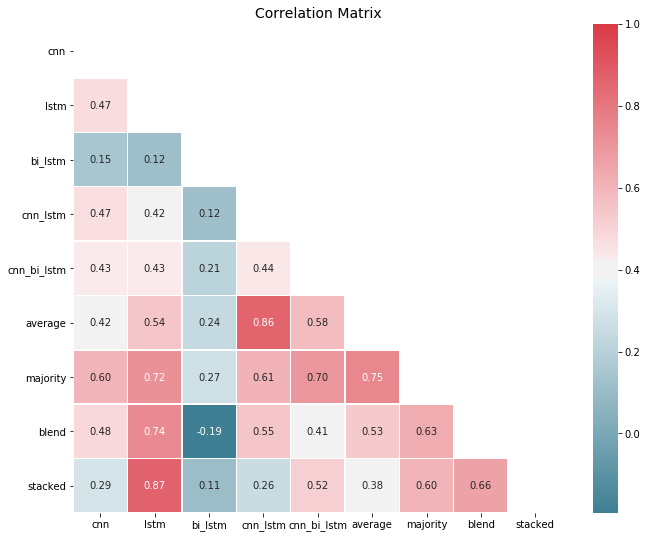

In [106]:
# corrmat(pred_df.corr(), inflate=False,show=False)
# plt.savefig('results/corr_matrix_full.png', bbox_inches='tight')
corrmat(pred_df.corr(), inflate=False)

## saving results

In [107]:
with open('results/ens_result.json','w') as fout:
    json.dump(acc_results,fout,indent=4)